In [1]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath(''))
others_path = os.path.join(current_dir, '..', '..', 'gpr')

others_path = os.path.abspath(others_path)
if others_path not in sys.path:
    sys.path.append(others_path)

import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Callable
import cvxpy as cp
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

from eos import EosProperties
from kernels import Kernel
import gaussianprocess
from constrainedgp import CGP
import sampling as sam
import prepare_ceft as pc
import prepare_pqcd as pp
import anal_helpers as anal
from pqcd.pQCD import pQCD
from constants import get_phi, ns
import tmg_samplers as tmg
import constrain_on_chempot as coc

from pathlib import Path
notebook_dir = Path.cwd()

from scipy.linalg import cholesky, solve_triangular, cho_solve
from scipy.stats import norm
import scipy as sp
import pandas as pd


from aquarel import load_theme
theme = (
        load_theme("gruvbox_dark")
        .set_font("serif")
        .set_grid(True, width=0.2)
        )


theme_white = (
        load_theme("scientific")
        .set_font("serif")
        .set_grid(True, width=0.2)
        .set_lines(width=2)
        .set_axes(top=True, right=True)
        .set_ticks(width_major=1.2, width_minor=0.9, size_major=11, size_minor=4, direction='in')
        #.set_tick_labels(right=True, top=True)
        .set_overrides({
            "ytick.right": "true",
            "xtick.top": "true",
        })
        .set_title(pad=15)
        )
theme_white.apply()

plot_dir = "/home/sam/thesis/writing/images/"

In [2]:
x = np.linspace(0,6,500)

In [3]:
K = Kernel("SE", sigma=1, l=1)
gp = gaussianprocess.GP(K)
K = gp.kernel.compute(x, x)

# prior gp

In [4]:
y_sams = gp.posterior(10, np.zeros_like(x), K, sampling = True)
y , sig= gp.posterior(mu = np.zeros_like(x), cov= K)

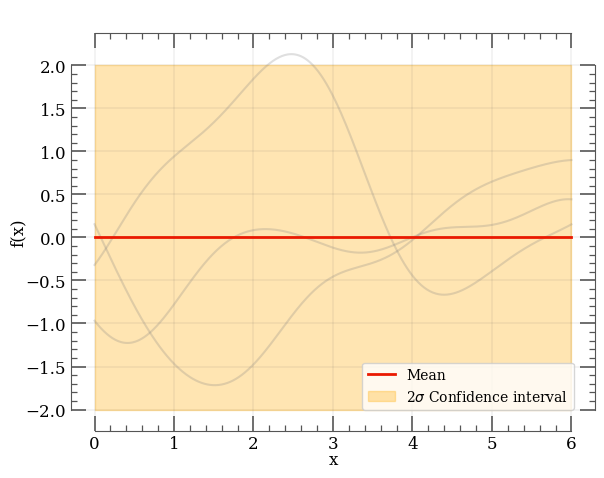

In [5]:
fig, ax = plt.subplots()

for i in range(3):
    ax.plot(x, y_sams[i], color='gray', alpha=0.25, linewidth=1.5)
ax.plot(x, y.flatten(), label='Mean', color='#ea1900')
ax.fill_between(
        x,
        y.flatten() - 2 * sig,
        y.flatten() + 2 * sig,
        color='#ffac00',
        alpha=0.3,
        label=r'2$\sigma$ Confidence interval',
        )
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()


theme_white.apply_transforms()
#ax.set_title("Gaussian Process Regression Example", fontsize=16)
ax.set_title(" ", fontsize=16)

#plt.savefig(plot_dir + "gp_example.png", dpi=300)
plt.show()


# posterior gp

In [13]:
n_ceft, cs2_ceft, cs2_ceft_l, cs2_ceft_u = anal.get_ceft_cs2()
cs2_sigma = pc.CI_to_sigma((cs2_ceft_l-cs2_ceft_u)/2, 95)
training_noise = cs2_sigma **2


In [14]:
n_test = np.linspace(n_ceft[0], 6, 100)
gp.fit(n_ceft, n_test, cs2_ceft, training_noise)

In [15]:
y_pred_samps = gp.posterior(sampling=True, n=10)
y_pred, sig_pred = gp.posterior(sampling=False)

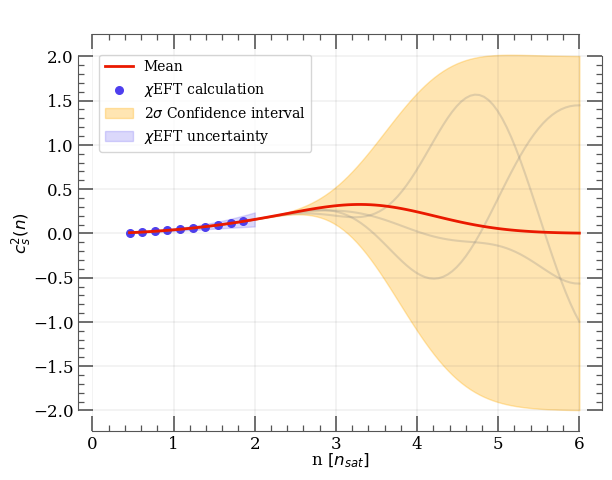

In [ ]:
for i in range(3):
    plt.plot(n_test, y_pred_samps[i], color='gray', alpha=0.25, linewidth=1.5)
plt.plot(n_test, y_pred.flatten(), label='Mean', color='#ea1900')
plt.scatter(n_ceft[::10], cs2_ceft[::10], color='#4e3fee', label=r'$\chi$EFT calculation', s=30)
plt.fill_between(
        n_test,
        y_pred.flatten() - 2 * sig_pred,
        y_pred.flatten() + 2 * sig_pred,
        color='#ffac00',
        alpha=0.3,
        label=r'2$\sigma$ Confidence interval',
        )
plt.fill_between(n_ceft, cs2_ceft_l, cs2_ceft_u, color='#4e3fee', alpha=0.2, label=r'$\chi$EFT uncertainty')
plt.xlabel('n $[n_{sat}]$')
plt.ylabel(r'$c_s^2(n)$')
plt.legend()

plt.title(" ", fontsize=16)

plt.xlim(0,)
theme_white.apply_transforms()

#plt.savefig(plot_dir + "gp_posterior_example.png", dpi=300)
plt.show()


# kernel: prior and posterior

In [19]:
K_prior = gp.kernel.compute(n_test, n_test)

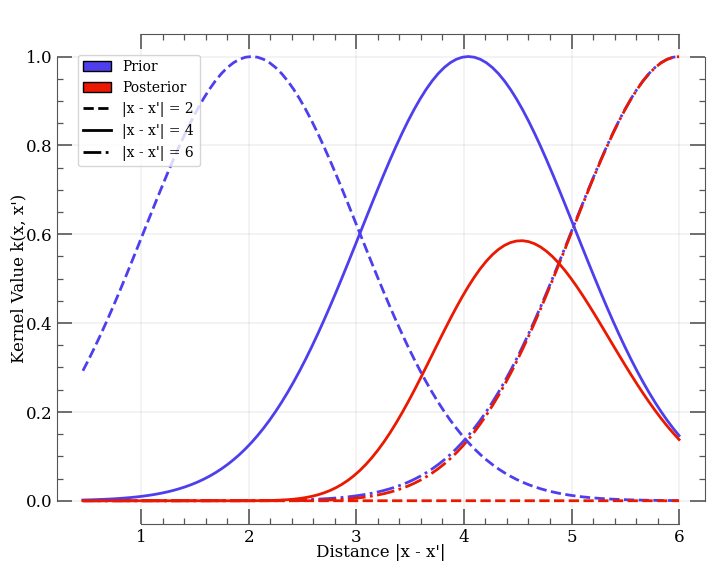

In [22]:
prior_color = '#4e3fee'
posterior_color = '#ea1900'

plt.figure(figsize=(8,6))

idx = np.searchsorted(n_test, 6)
plt.plot(n_test, K_prior[idx], '-.', color=prior_color)
plt.plot(n_test, gp.cov_star[idx], '-.', color=posterior_color)

idx = np.searchsorted(n_test, 2)
plt.plot(n_test, K_prior[idx], '--', color=prior_color)
plt.plot(n_test, gp.cov_star[idx], '--', color=posterior_color)

idx = np.searchsorted(n_test, 4)
plt.plot(n_test, K_prior[idx], color=prior_color)
plt.plot(n_test, gp.cov_star[idx], color=posterior_color)

legend_handles = [
    Patch(facecolor=prior_color, edgecolor='k', label='Prior'),
    Patch(facecolor=posterior_color, edgecolor='k', label='Posterior'),
    plt.Line2D([0], [0], color='k', linestyle='--', label='|x - x\'| = 2'),
    plt.Line2D([0], [0], color='k', linestyle='-', label='|x - x\'| = 4'),
    plt.Line2D([0], [0], color='k', linestyle='-.', label='|x - x\'| = 6'),
]

plt.xlabel("Distance |x - x'|")
plt.ylabel("Kernel Value k(x, x')")
plt.legend(handles=legend_handles, loc='upper left')
plt.title(" ", fontsize=16)

theme_white.apply_transforms()
plt.show()


# different lengthscales

In [32]:
samples = []


kern = Kernel("SE", sigma=1, l=0.1)
gp = gaussianprocess.GP(kern)

K_1 = kern.compute(x, x)
y_sams = gp.posterior(1, np.zeros_like(x), K_1, sampling = True)
samples.append(y_sams[0])


kern = Kernel("SE", sigma=1, l=1)
K_2 = kern.compute(x, x)
y_sams = gp.posterior(1, np.zeros_like(x), K_2, sampling = True)
samples.append(y_sams[0])


kern = Kernel("SE", sigma=1, l=5)
K_3 = kern.compute(x, x)

y_sams = gp.posterior(1, np.zeros_like(x), K_3, sampling = True)
samples.append(y_sams[0])

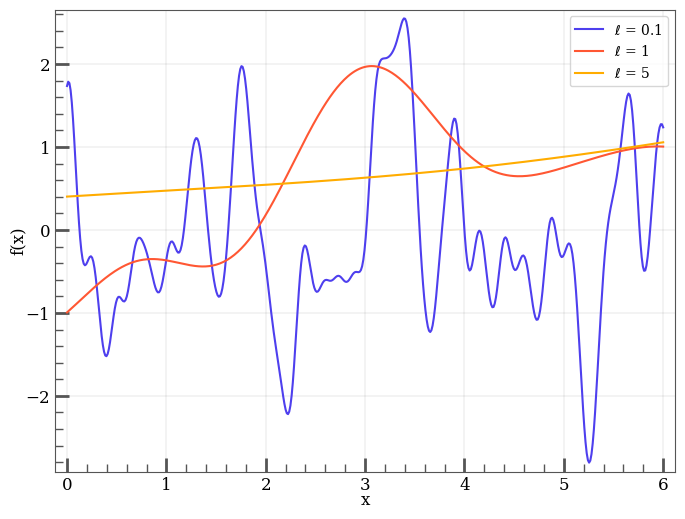

In [ ]:
plt.figure(figsize=(8,6))

lengthscales = [0.1, 1, 5]
colors = ['#4e3fee', '#ff5733', '#ffac00']
for i, sample in enumerate(samples):
    plt.plot(x, sample, color=colors[i], linewidth=1.5, label=fr'$\ell$ = {lengthscales[i]}')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
#plt.savefig(plot_dir + "se_prior.png", dpi=300)
plt.show()



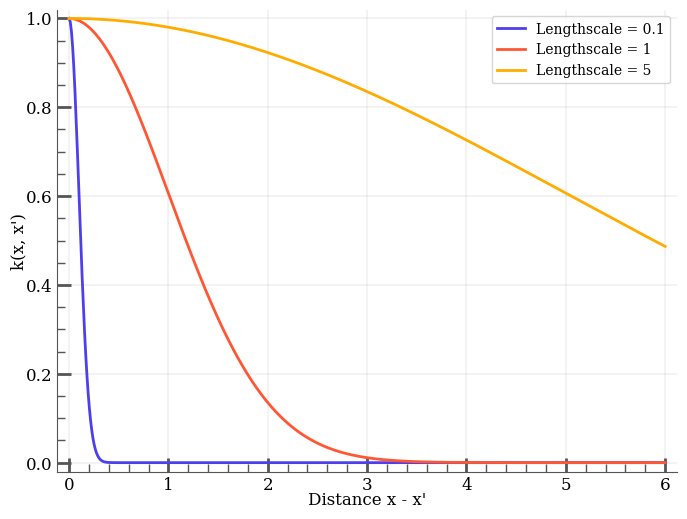

In [14]:
plt.figure(figsize=(8,6))
plt.plot(x, K_1[0], label="Lengthscale = 0.1", color=colors[0])
plt.plot(x, K_2[0], label="Lengthscale = 1", color=colors[1])
plt.plot(x, K_3[0], label="Lengthscale = 5", color=colors[2])
plt.xlabel("Distance x - x'")
plt.ylabel("k(x, x')")
plt.legend()
plt.grid(True)
#plt.savefig(plot_dir + "se_lengthscale.png", dpi=300)
plt.show()


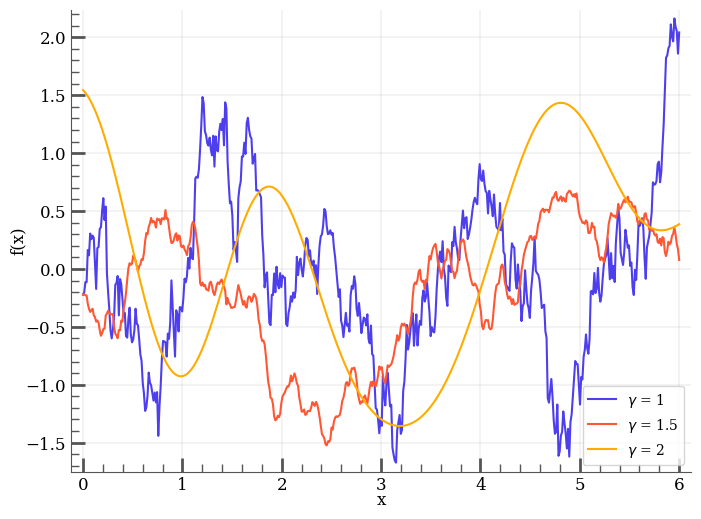

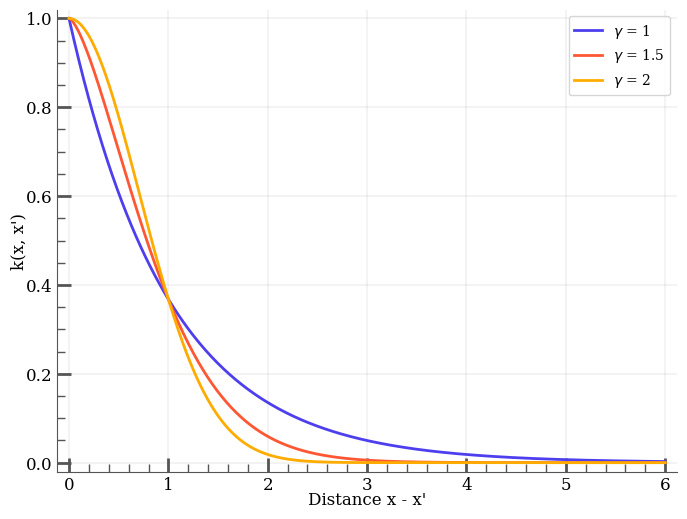

In [15]:
samples = []


kern = Kernel("GE", sigma=1, l=1, gamma = 1)
gp = gaussianprocess.GP(kern)

K_1 = kern.compute(x, x)
y_sams = gp.posterior(1, np.zeros_like(x), K_1, sampling = True)
samples.append(y_sams[0])


kern = Kernel("GE", sigma=1, l=1, gamma = 1.5)
K_2 = kern.compute(x, x)
y_sams = gp.posterior(1, np.zeros_like(x), K_2, sampling = True)
samples.append(y_sams[0])


kern = Kernel("GE", sigma=1, l=1, gamma = 2)
K_3 = kern.compute(x, x)

y_sams = gp.posterior(1, np.zeros_like(x), K_3, sampling = True)
samples.append(y_sams[0])

plt.figure(figsize=(8,6))

gamma = [1, 1.5, 2]
colors = ['#4e3fee', '#ff5733', '#ffac00']
for i, sample in enumerate(samples):
    plt.plot(x, sample, color=colors[i], linewidth=1.5, label=f'$\gamma$ = {gamma[i]}')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
#plt.savefig(plot_dir + "ge_prior.png", dpi=300)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x, K_1[0], label=f"$\gamma$ = 1", color=colors[0])
plt.plot(x, K_2[0], label=f"$\gamma$ = 1.5", color=colors[1])
plt.plot(x, K_3[0], label=f"$\gamma$ = 2", color=colors[2])
plt.xlabel("Distance x - x'")
plt.ylabel("k(x, x')")
plt.legend()
plt.grid(True)
#plt.savefig(plot_dir + "ge_gamma.png", dpi=300)
plt.show()


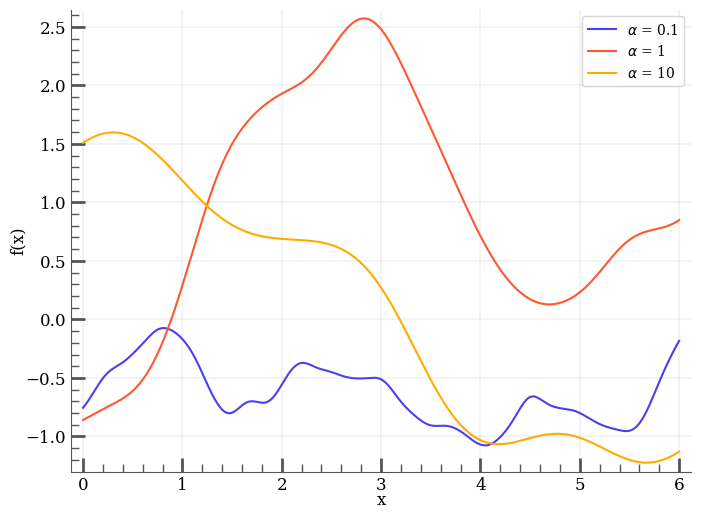

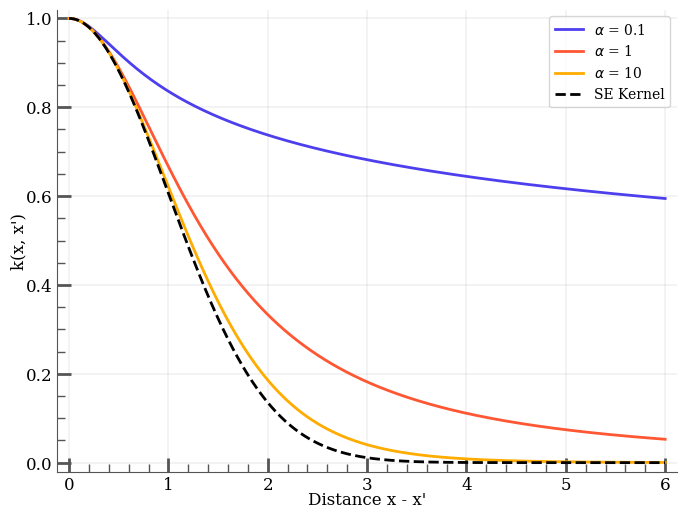

In [16]:
samples = []


kern = Kernel("RQ", sigma=1, l=1, alpha = 0.1)
gp = gaussianprocess.GP(kern)

K_1 = kern.compute(x, x)
y_sams = gp.posterior(1, np.zeros_like(x), K_1, sampling = True)
samples.append(y_sams[0])


kern = Kernel("RQ", sigma=1, l=1, alpha = 1)
K_2 = kern.compute(x, x)
y_sams = gp.posterior(1, np.zeros_like(x), K_2, sampling = True)
samples.append(y_sams[0])


kern = Kernel("RQ", sigma=1, l=1, alpha = 5)
K_3 = kern.compute(x, x)

y_sams = gp.posterior(1, np.zeros_like(x), K_3, sampling = True)
samples.append(y_sams[0])

plt.figure(figsize=(8,6))

kern = Kernel("SE", sigma=1, l=1)
K_4 = kern.compute(x, x)
y_sams = gp.posterior(1, np.zeros_like(x), K_4, sampling = True)
samples.append(y_sams[0])

alpha = [0.1, 1, 10]
colors = ['#4e3fee', '#ff5733', '#ffac00', '#00b894']
for i, sample in enumerate(samples):
    if i < 3:
        plt.plot(x, sample, color=colors[i], linewidth=1.5, label=fr'$\alpha$ = {alpha[i]}')
 

plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
#plt.savefig(plot_dir + "rq_prior.png", dpi=300)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x, K_1[0], label=fr"$\alpha$ = 0.1", color=colors[0])
plt.plot(x, K_2[0], label=fr"$\alpha$ = 1", color=colors[1])
plt.plot(x, K_3[0], label=fr"$\alpha$ = 10", color=colors[2])
plt.plot(x, K_4[0], label="SE Kernel", color='k', linestyle='--')
plt.xlabel("Distance x - x'")
plt.ylabel("k(x, x')")
plt.legend()
plt.grid(True)
#plt.savefig(plot_dir + "rq_alpha.png", dpi=300)
plt.show()


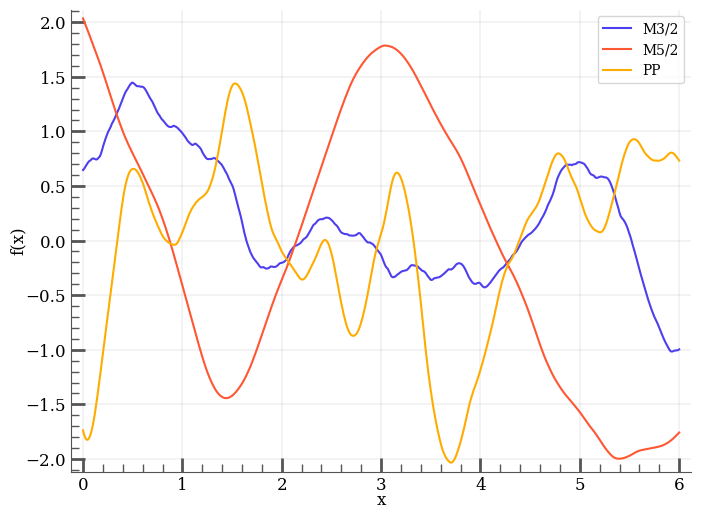

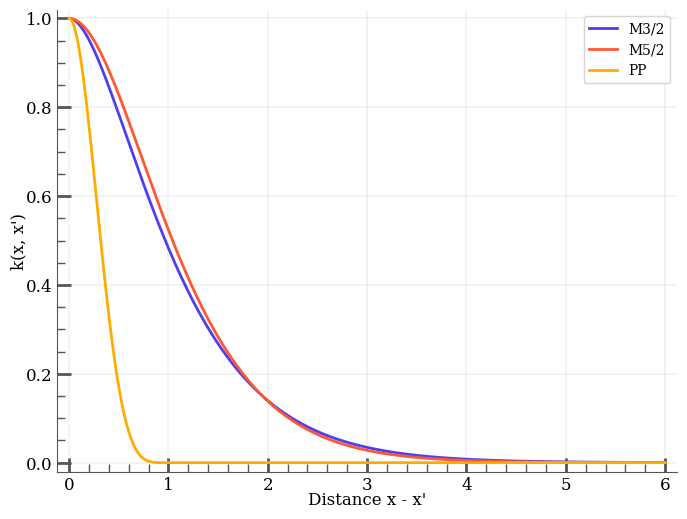

In [23]:
samples = []


kern = Kernel("M32", sigma=1, l=1)
gp = gaussianprocess.GP(kern)

K_1 = kern.compute(x, x)
y_sams = gp.posterior(1, np.zeros_like(x), K_1, sampling = True)
samples.append(y_sams[0])

kern = Kernel("M52", sigma=1, l=1)
K_2 = kern.compute(x, x)
y_sams = gp.posterior(1, np.zeros_like(x), K_2, sampling = True)
samples.append(y_sams[0])

kern = Kernel("PP", sigma=1, l=1, q = 2)
K_3 = kern.compute(x, x)
y_sams = gp.posterior(1, np.zeros_like(x), K_3, sampling = True)
samples.append(y_sams[0])

plt.figure(figsize=(8,6))

q_values = [r"M3/2", r"M5/2", "PP"]
colors = ['#4e3fee', '#ff5733', '#ffac00']
for i, sample in enumerate(samples):
    plt.plot(x, sample, color=colors[i], linewidth=1.5, label=f'{q_values[i]}')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.savefig(plot_dir + "matern_pp_prior.png", dpi=300)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x, K_1[0], label=f"M3/2", color=colors[0])
plt.plot(x, K_2[0], label=f"M5/2", color=colors[1])
plt.plot(x, K_3[0], label=f"PP", color=colors[2])
plt.xlabel("Distance x - x'")
plt.ylabel("k(x, x')")
#plt.xlim(0,1)
plt.legend()
plt.grid(True)
plt.savefig(plot_dir + "matern_pp.png", dpi=300)
plt.show()


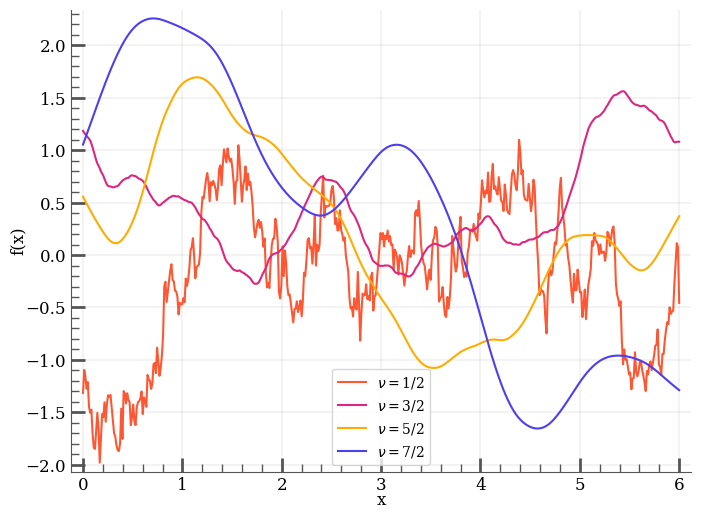

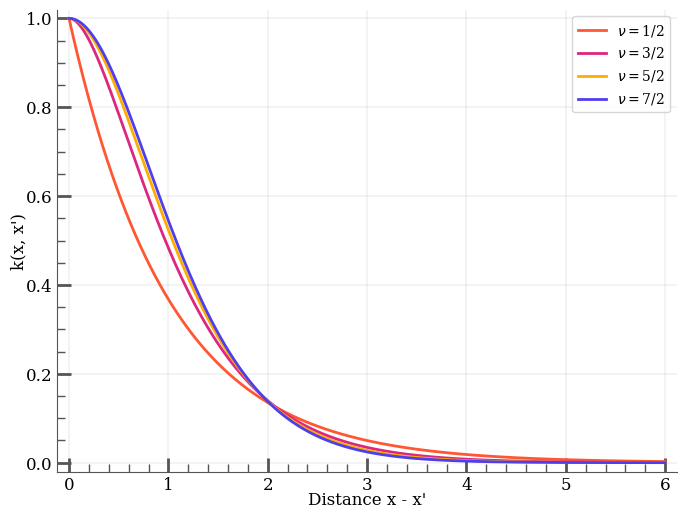

In [44]:
samples = []

kern = Kernel("M12", sigma=1, l=1)
gp = gaussianprocess.GP(kern)
K_0 = kern.compute(x, x)
y_sams = gp.posterior(1, np.zeros_like(x), K_0, sampling = True)
samples.append(y_sams[0])


kern = Kernel("M32", sigma=1, l=1)
K_1 = kern.compute(x, x)
y_sams = gp.posterior(1, np.zeros_like(x), K_1, sampling = True)
samples.append(y_sams[0])

kern = Kernel("M52", sigma=1, l=1)
K_2 = kern.compute(x, x)
y_sams = gp.posterior(1, np.zeros_like(x), K_2, sampling = True)
samples.append(y_sams[0])


#kern = Kernel("PP", sigma=1, l=1, q = 2)
kern = Kernel("M72", sigma=1, l=1)
K_3 = kern.compute(x, x)
y_sams = gp.posterior(1, np.zeros_like(x), K_3, sampling = True)
samples.append(y_sams[0])

plt.figure(figsize=(8,6))

q_values = ["1/2", "3/2", "5/2", "7/2"]
colors = ['#ff5733', '#DC267F', '#ffac00', '#4e3fee']
for i, sample in enumerate(samples):
    plt.plot(x, sample, color=colors[i], linewidth=1.5, label=fr'$\nu =${q_values[i]}')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.savefig(plot_dir + "matern_prior.png", dpi=300)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(x, K_0[0], label=fr"$\nu = $1/2", color=colors[0])
plt.plot(x, K_1[0], label=fr"$\nu = $3/2", color=colors[1])
plt.plot(x, K_2[0], label=fr"$\nu = $5/2", color=colors[2])
#plt.plot(x, K_3[0], label=f"PP", color=colors[2])
plt.plot(x, K_3[0], label=fr"$\nu = $7/2", color=colors[3])
plt.xlabel("Distance x - x'")
plt.ylabel("k(x, x')")
#plt.xlim(0,1)
plt.legend()
plt.grid(True)
plt.savefig(plot_dir + "matern_nu.png", dpi=300)
plt.show()


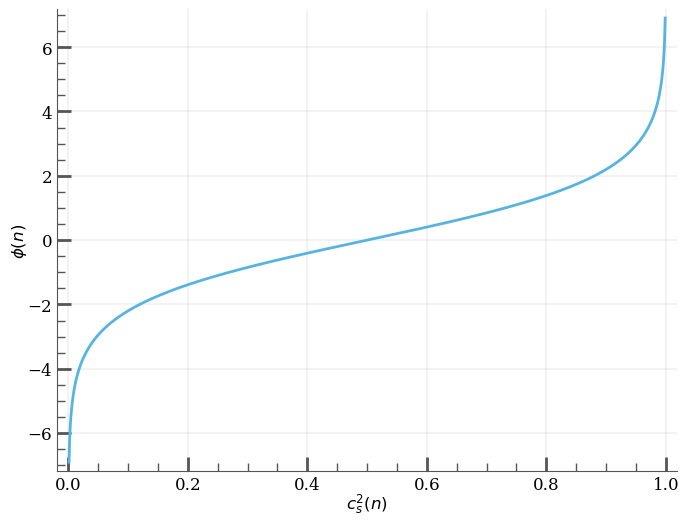

In [32]:
c = np.linspace(0,1,1000)
ph = get_phi(c)

plt.figure(figsize=(8,6))
plt.plot(c, ph)
plt.xlabel(r'$c_s^2(n)$')
plt.ylabel(r'$\phi(n)$')
plt.show()